In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Familiar stack packages
import numpy as np
import astropy.table as astTable
from lsst.daf.butler import Butler
import lsst.geom as geom
import xlens
from xlens.process_pipe.anacal_detect import AnacalDetectPipeConfig, AnacalDetectPipe
from astropy.io import ascii as astascii
import fitsio

from astropy.visualization import ZScaleInterval
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.integrate as integrate
import lsst.afw.image as afwImage
import anacal

In [3]:
if False:
    full = astTable.Table.read("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim2.fits")
    index = fitsio.read("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/valid.fits")
    full = full[index]
    full["index"] = np.arange(len(full), dtype=int)
    full.write("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim3.fits")
if False:
    full = astTable.Table.read("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim3.fits")
    index = fitsio.read("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/valid.fits")
    left = full[index]
    patch_db = left["patch"]
    patch_x = patch_db // 100
    patch_y = patch_db % 100
    patch_id = patch_x + patch_y * 9
    left.write("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/left.fits")

In [78]:
full = astTable.Table.read("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim3.fits")

ndiv_dict = {
    "autumn": 2,
    "spring": 3,
}

for fd in ["autumn", "spring"]:
    ndiv = ndiv_dict[fd]
    mask = full["field"] == fd
    ra = np.array(full["ra"][mask])
    if fd == "autumn":
        ra[ra < 50] += 360
    mid = np.quantile(ra, np.linspace(0, 1, ndiv + 1))
    mid[0] = mid[0] - 0.1
    mid[-1] = mid[-1] + 0.1
    for i in range(ndiv):
        seg_mask = (ra > mid[i]) & (ra <= mid[i + 1])
        idx = np.where(mask)[0][seg_mask]
        full["field"][idx] = [fd + str(i + 1)] * len(idx)
full.write("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim4.fits")

In [4]:
obs_repo = '/lustre/work/xiangchong.li/work/hsc_s23b_sim'
obs_collection = 'version1/image'

obs_butler = Butler(obs_repo, collections=obs_collection)
obs_registry = obs_butler.registry
skymap = obs_butler.get('skyMap', skymap="hsc")

config = AnacalDetectPipeConfig()
config.anacal.force_size = False
config.anacal.num_epochs = 8
config.anacal.num_epochs_deblend = 1
config.anacal.use_average_psf = False
config.anacal.badMaskPlanes = ['BAD', 'CR', 'CROSSTALK', 'NO_DATA', 'REJECTED', 'SAT', 'SUSPECT', 'UNMASKEDNAN', 'SENSOR_EDGE', 'STREAK', 'VIGNETTED']
task = AnacalDetectPipe(config=config)

In [27]:
import glob
import fitsio

full = fitsio.read("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim2.fits")
full = full[(full["tract"] == 8520)]
entry = full[10]
tract_id = entry["tract"]
patch_db = entry["patch"]
patch_x = patch_db // 100
patch_y = patch_db % 100
patch_id = patch_x + patch_y * 9
tract_id = 9579
patch_id = 38
print(tract_id, patch_id)

9579 38


In [28]:
%%time
db_dir = "/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/database/"
outdir = f"{db_dir}/s23b-anacal/tracts/{tract_id}/{patch_id}"
out_fname = os.path.join(outdir, "detect.fits")
patch_info = skymap[tract_id][patch_id]
wcs = patch_info.getWcs()
bbox = patch_info.getOuterBBox()
image_dir = (
    "/lustre/HSC_DR/hsc_ssp/dr4/s23b/data/s23b_wide/unified/deepCoadd_calexp"
)
files = glob.glob(os.path.join(image_dir, f"{tract_id}/{patch_id}/i/*"))
fname = files[0]
exposure = afwImage.ExposureF.readFits(fname)
base_dir = "/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/database/"
mask_dir = f"{base_dir}/s23b-brightStarMask/tracts_mask/{tract_id}/{patch_id}"
mask_fname = os.path.join(mask_dir, "mask.fits")
bmask = fitsio.read(mask_fname)

sp_dir = f"{db_dir}/s23b-brightGalaxyMask/tracts/{tract_id}/{patch_id}"
sp_fname = os.path.join(sp_dir, "catalog.fits")
if os.path.isfile(sp_fname):
    spg = fitsio.read(sp_fname)
else:
    spg = None

seed = tract_id * 1000 + patch_id
data = task.anacal.prepare_data(
    exposure=exposure,
    seed=seed,
    noise_corr=None,
    detection=None,
    band=None,
    skyMap=skymap,
    tract=tract_id,
    patch=patch_id,
    star_mask_array=bmask,
    star_cat=spg,
)
catalog = task.anacal.run(**data)

gm = (catalog["mask_value"] < 30) & (catalog["is_primary"])
catalog = catalog[gm]

CPU times: user 29.8 s, sys: 6.34 s, total: 36.1 s
Wall time: 36.7 s


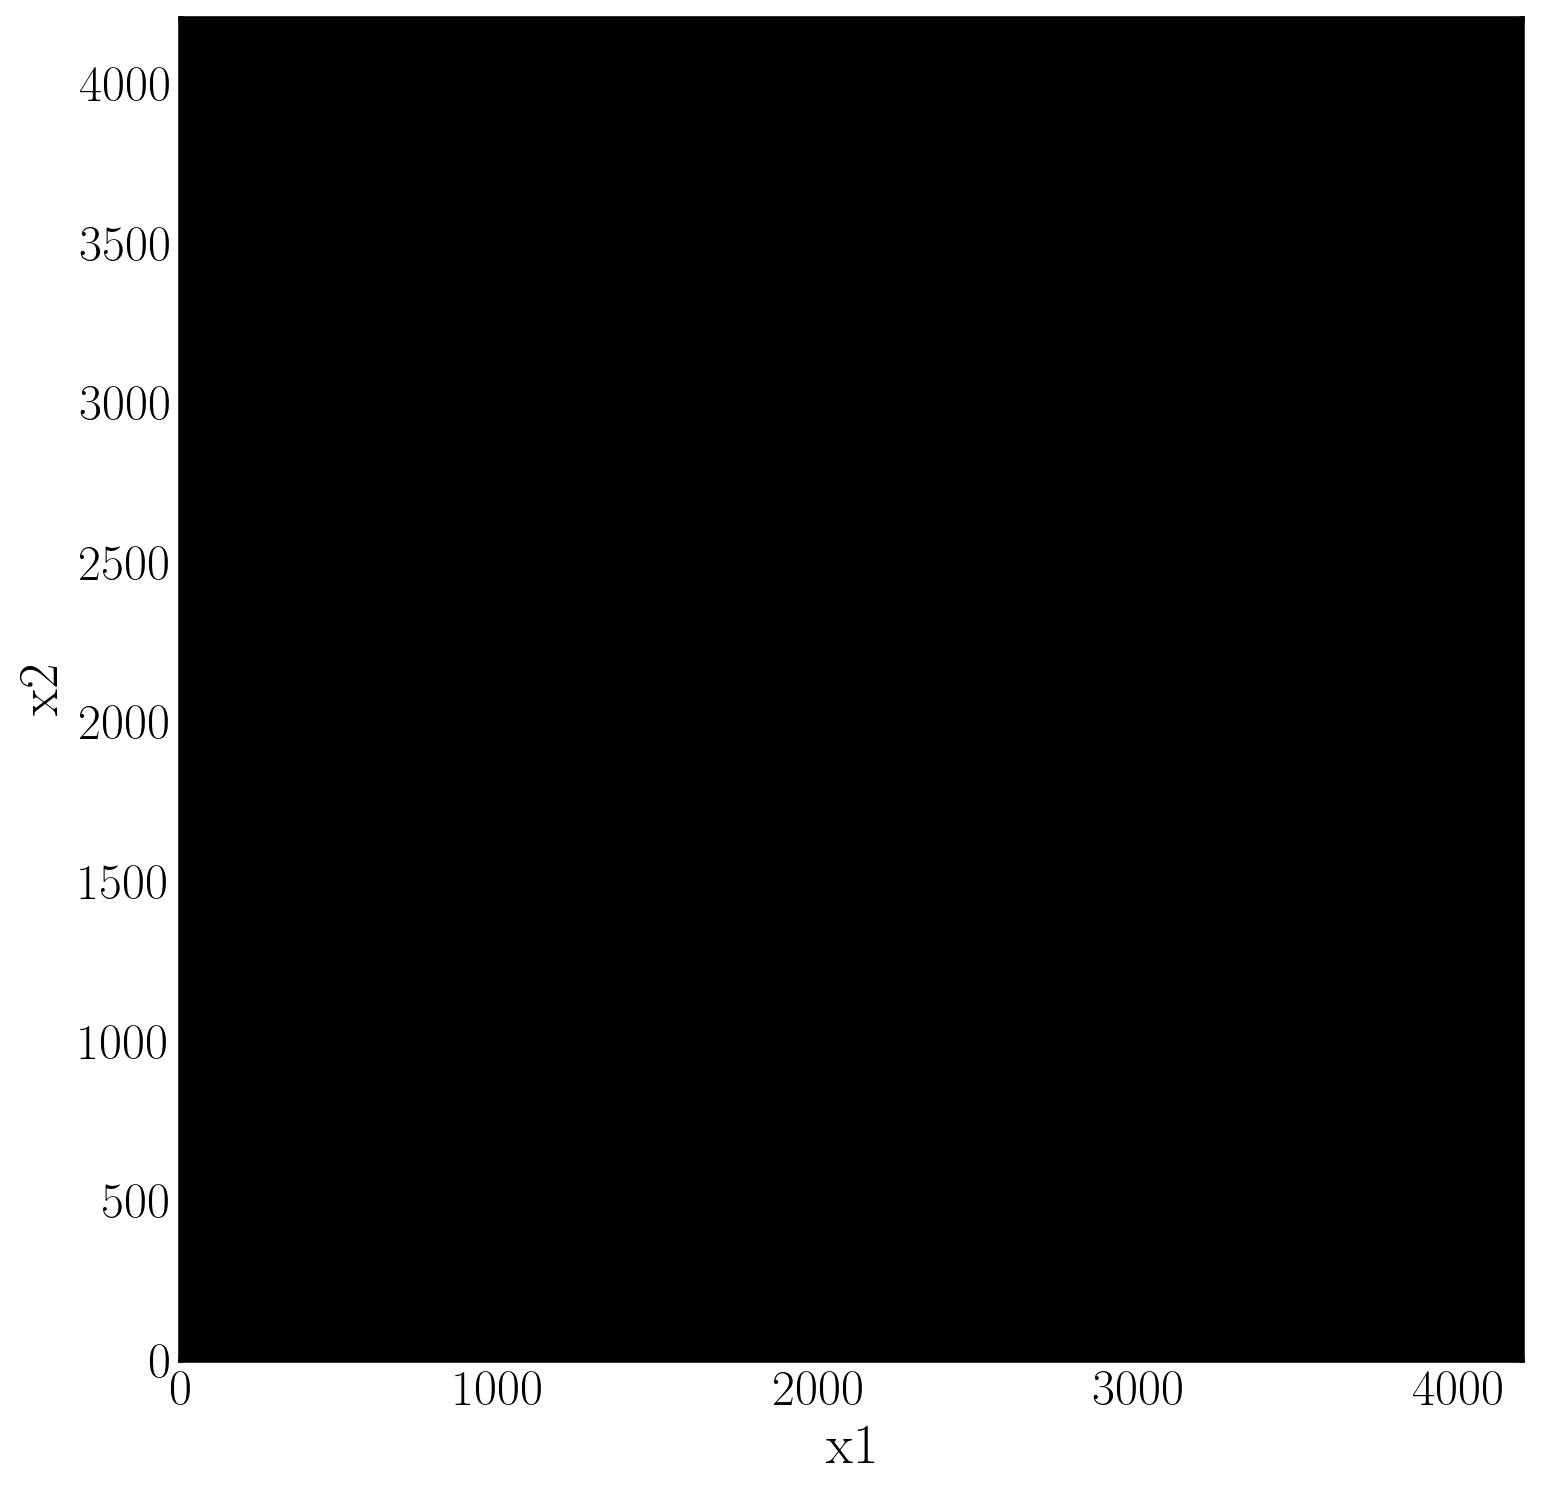

In [29]:
image = data["gal_array"]
# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

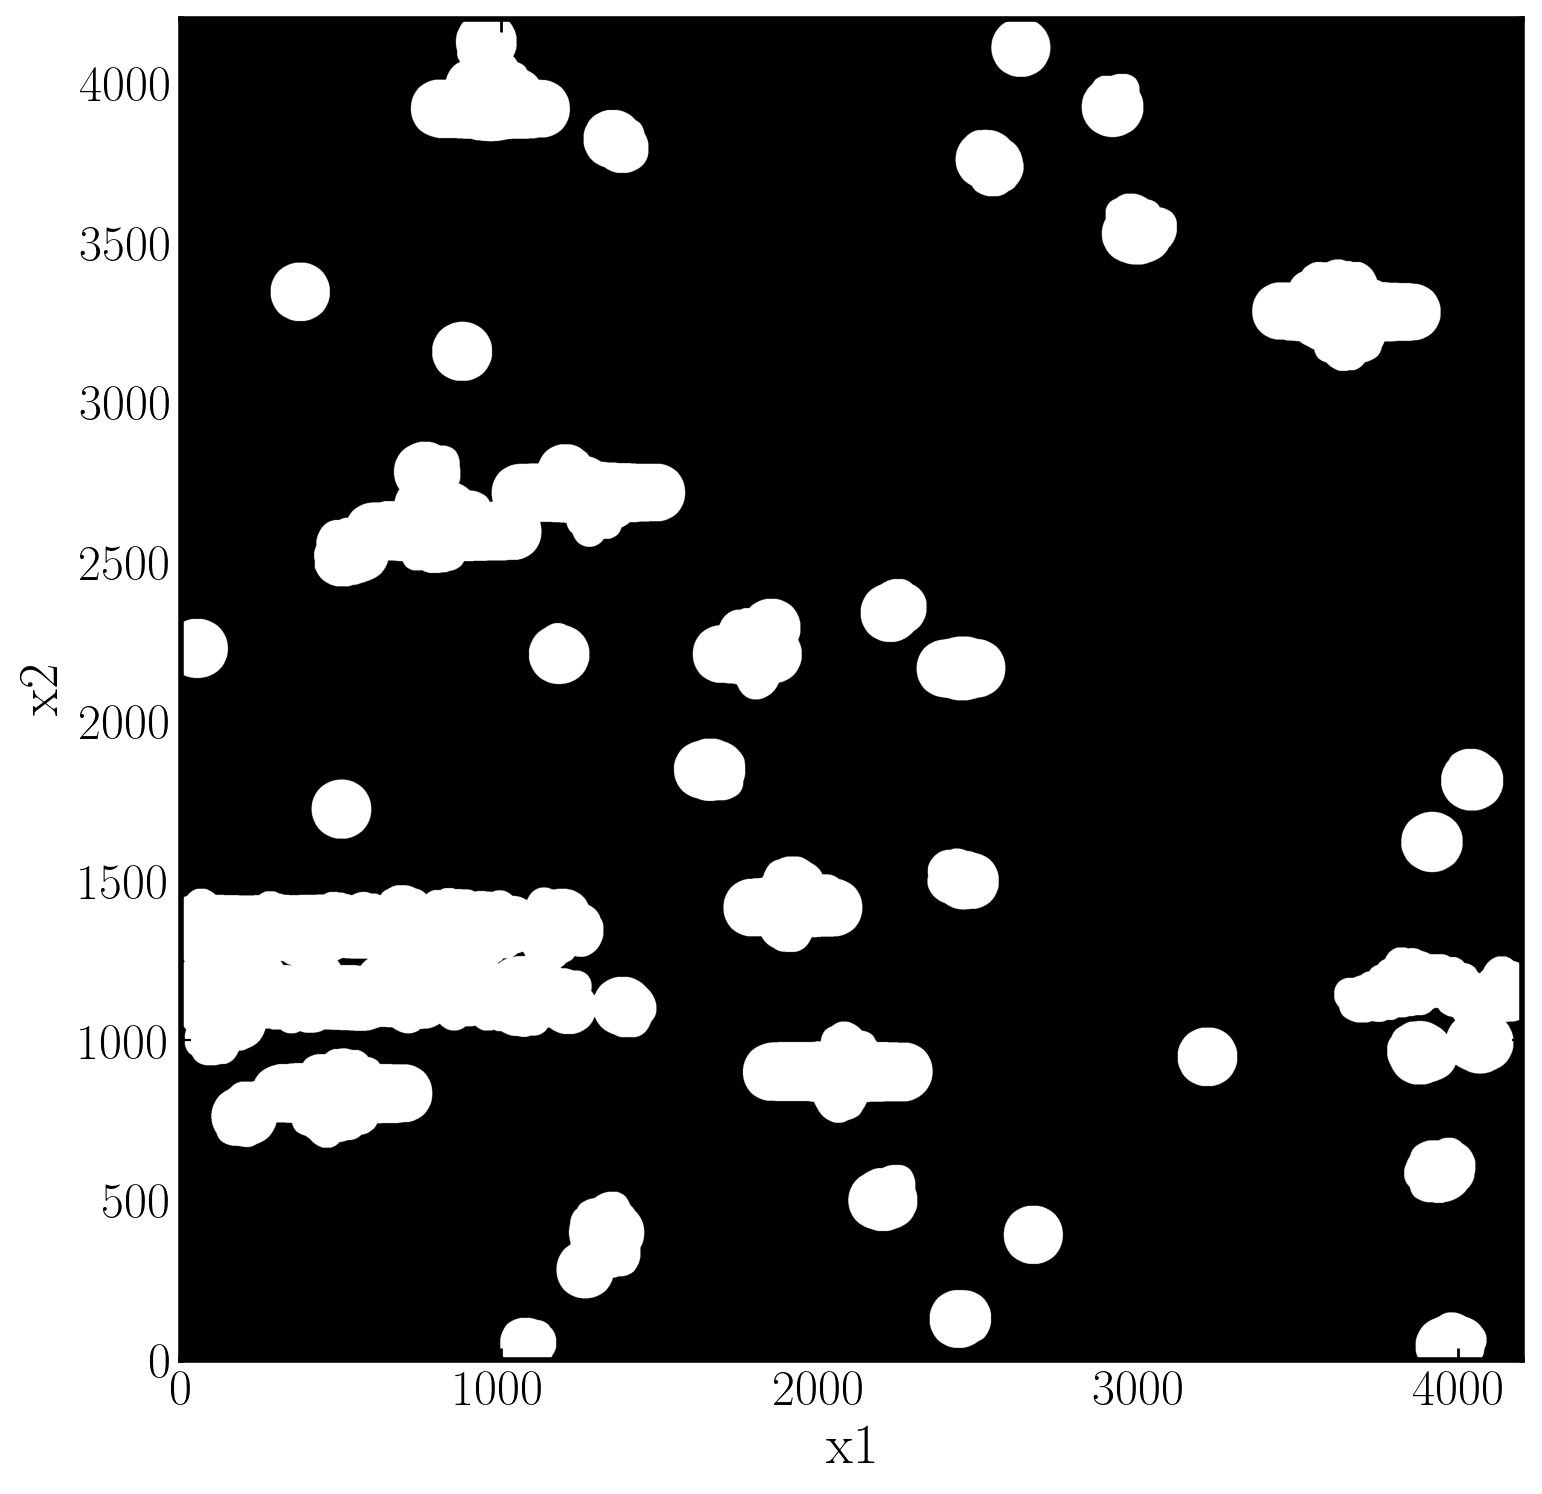

In [36]:

#image = data["mask_array"]
image = bmask
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray')
ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

In [37]:
spg

array([(2905.71229684,  924.61841227,   139.09945399),
       (2904.89074182,  922.55098038,   137.47073836),
       (3879.85224344,  958.7969675 , 24944.61468511),
       (4484.27707309,  792.68852682,    72.96034687),
       (2097.62550017, -843.50316611,   277.26170247),
       (2068.30740203,  874.39798392,   126.99282418)],
      dtype=[('x', '>f8'), ('y', '>f8'), ('r', '>f8')])

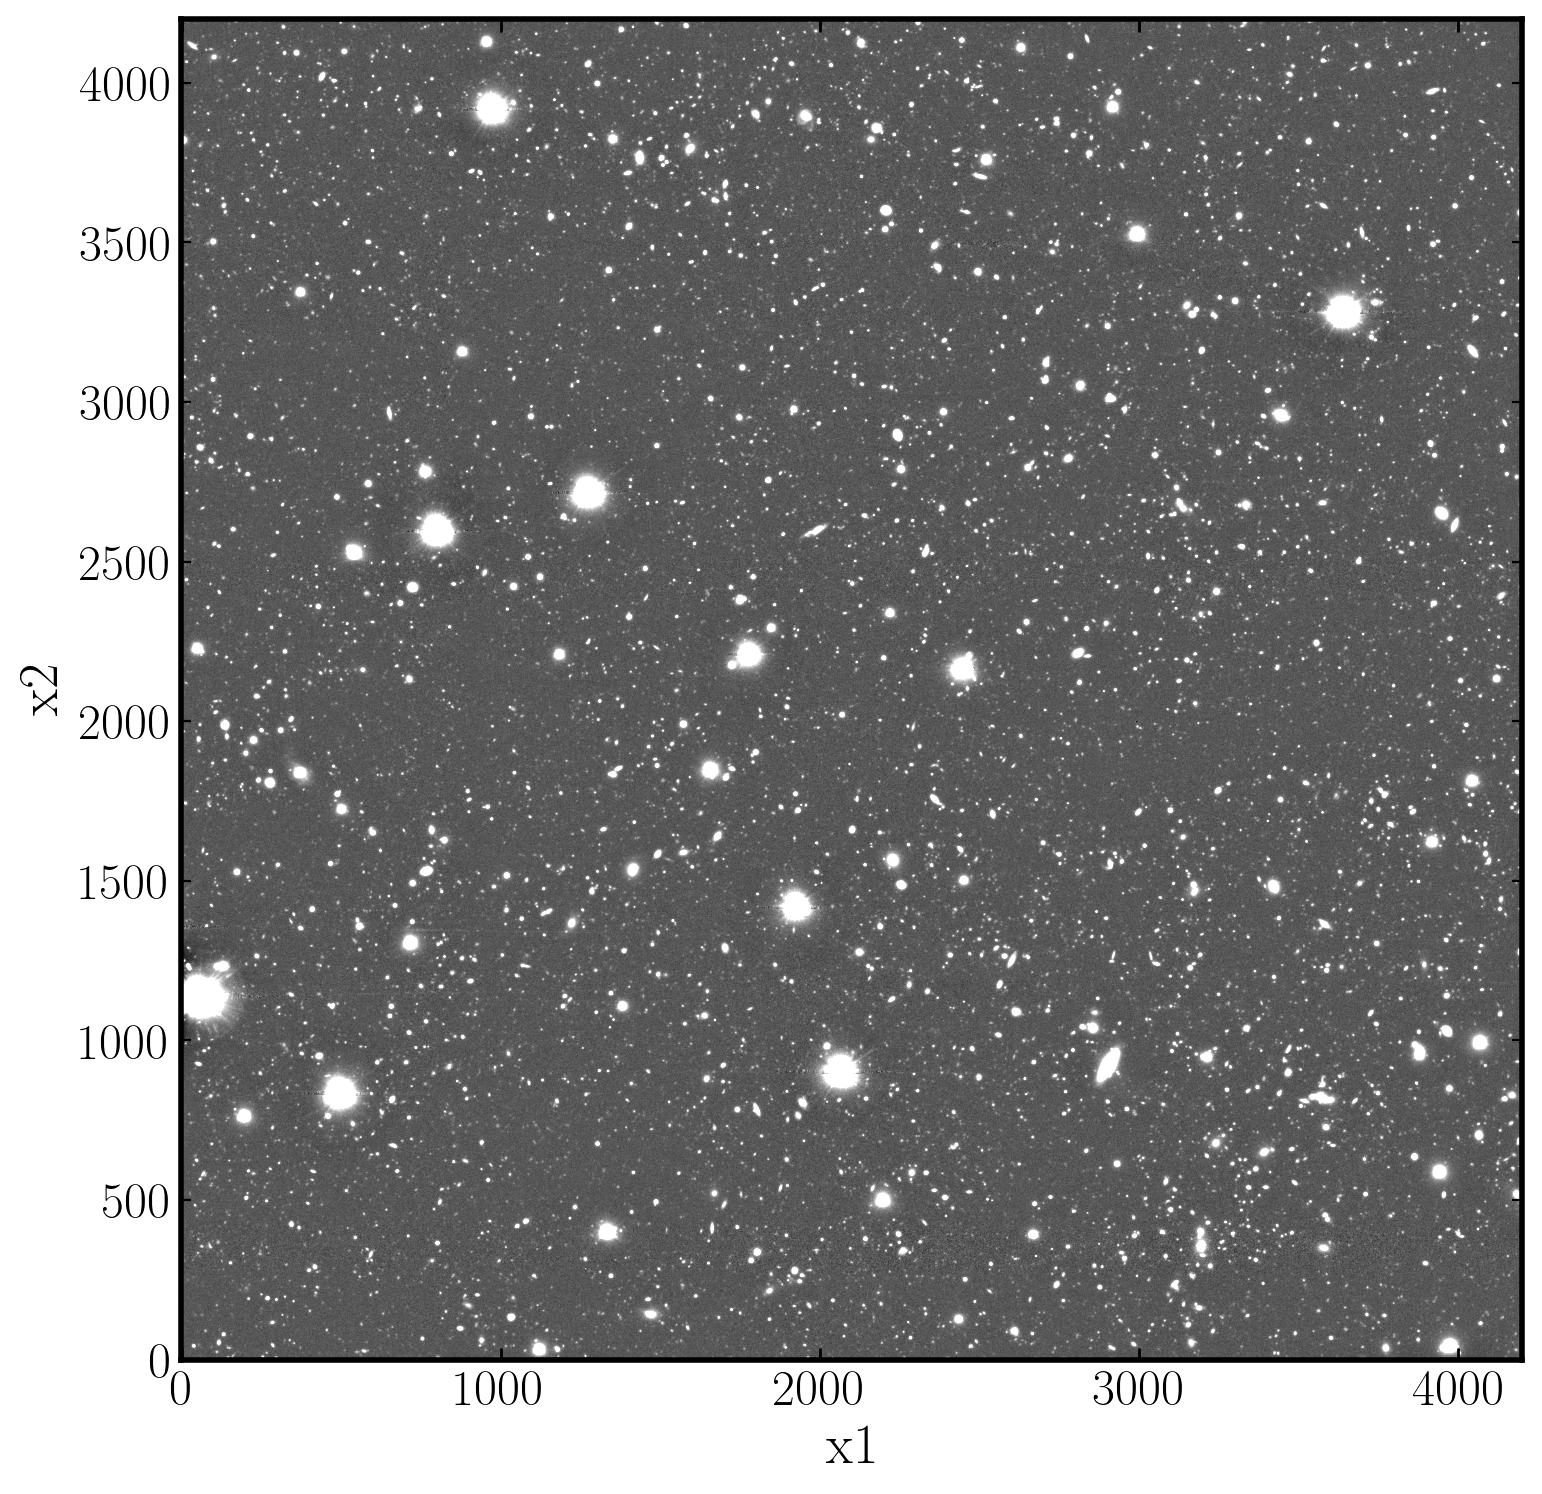

In [30]:
image = exposure.image.array
# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

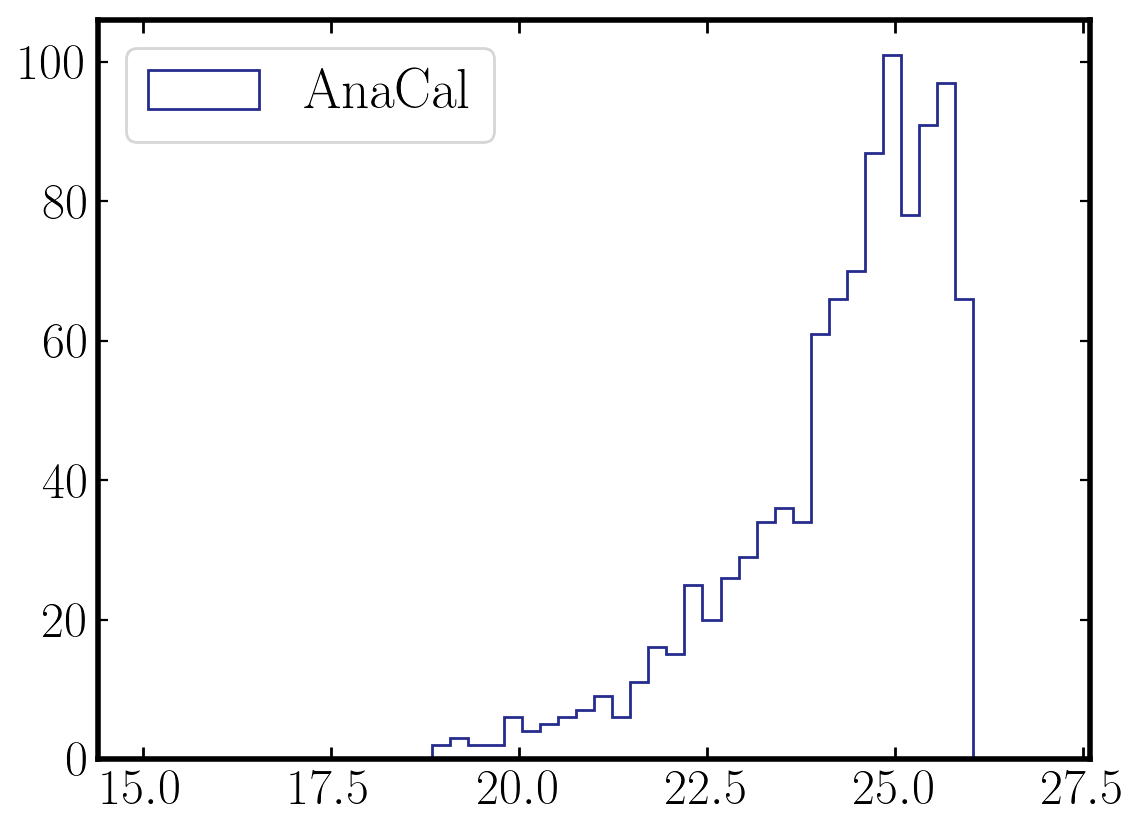

In [9]:
plt.hist(27 - np.log10(catalog["flux"]) * 2.5, histtype="step", density=False, bins=50, range=(15, 27), label="AnaCal")
plt.legend()

-94.89448971972912
90.32086642755974


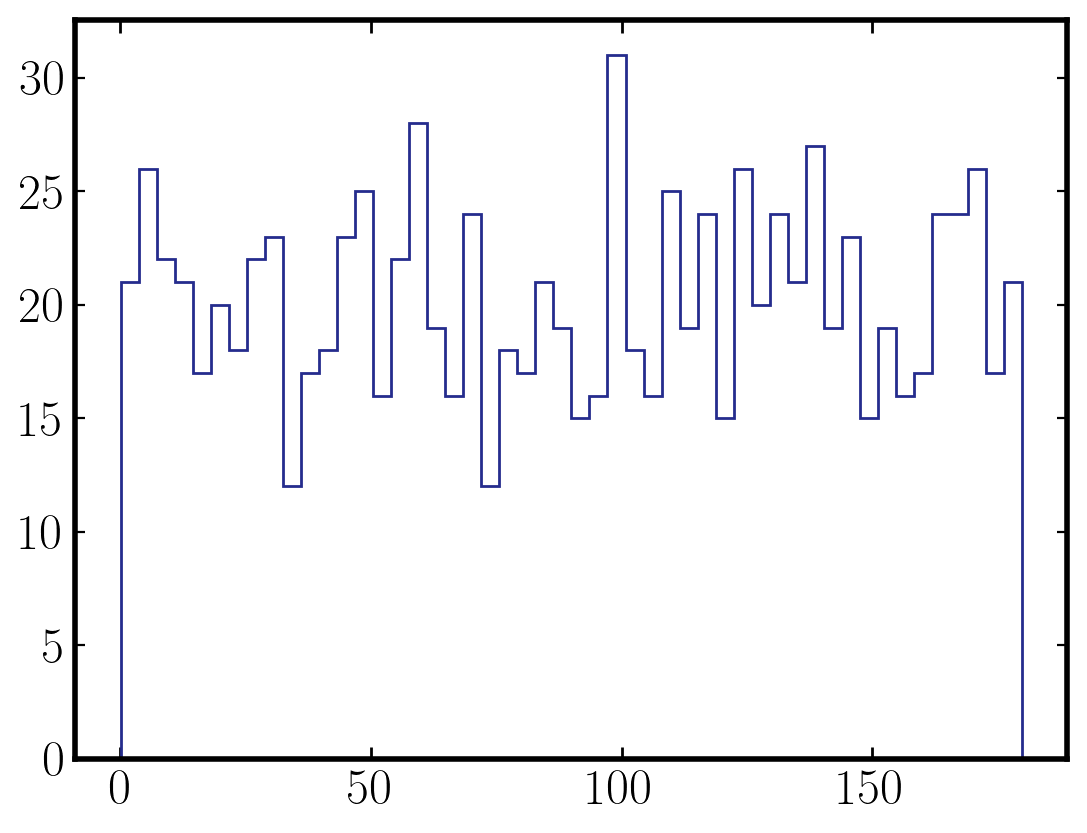

In [10]:
plt.close()
plt.hist(np.degrees(catalog["t"]) % 180, histtype="step", density=False, bins=50)
print(np.min(np.degrees(catalog["t"])))
print(np.max(np.degrees(catalog["t"])))

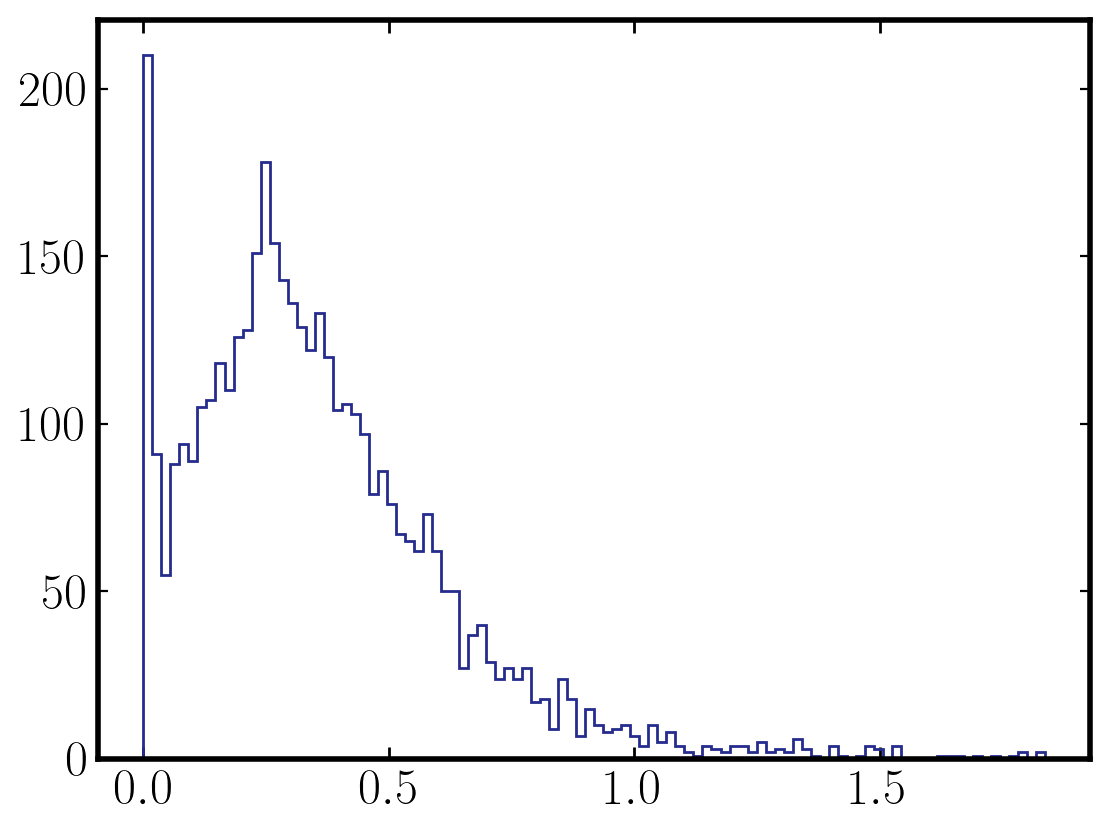

In [257]:
plt.close()
_=plt.hist(np.sqrt(catalog["a1"] **2 + catalog["a2"] **2), histtype="step", density=False, bins=100)

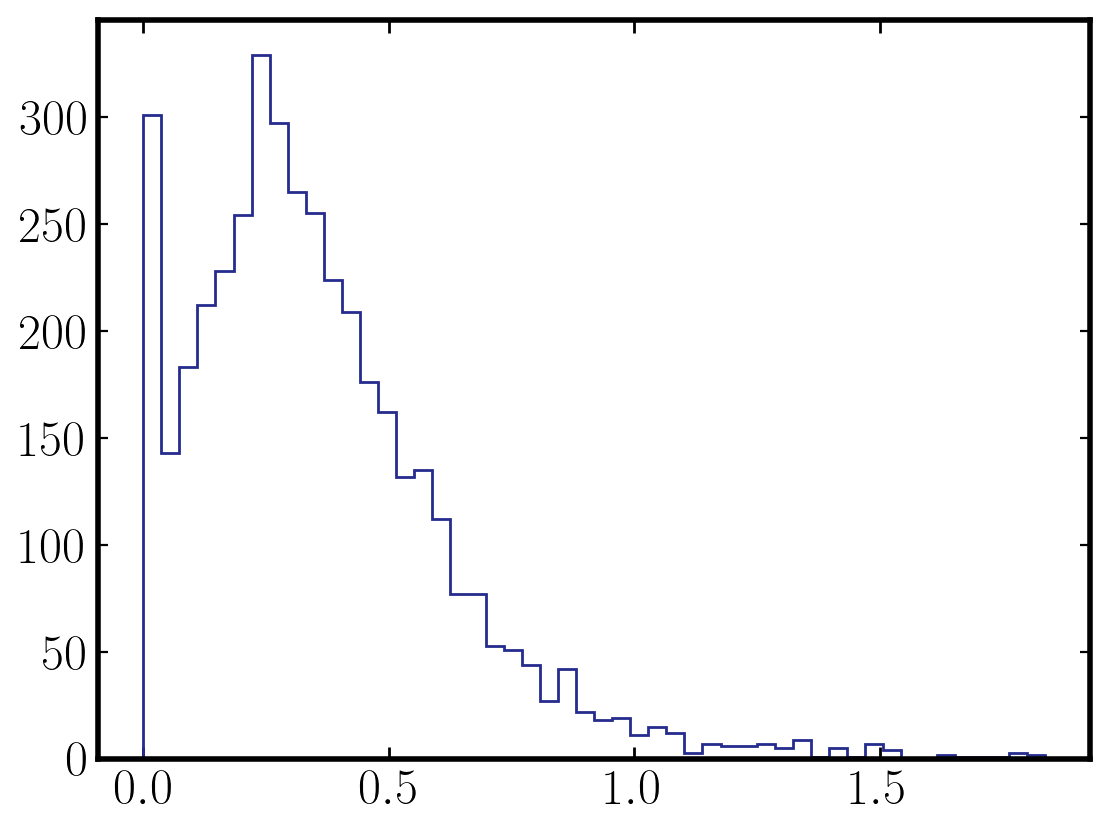

In [258]:
plt.close()
_=plt.hist(np.sqrt(catalog["a2"] ** 2.0 + catalog["a1"] ** 2.0), histtype="step", density=False, bins=50)

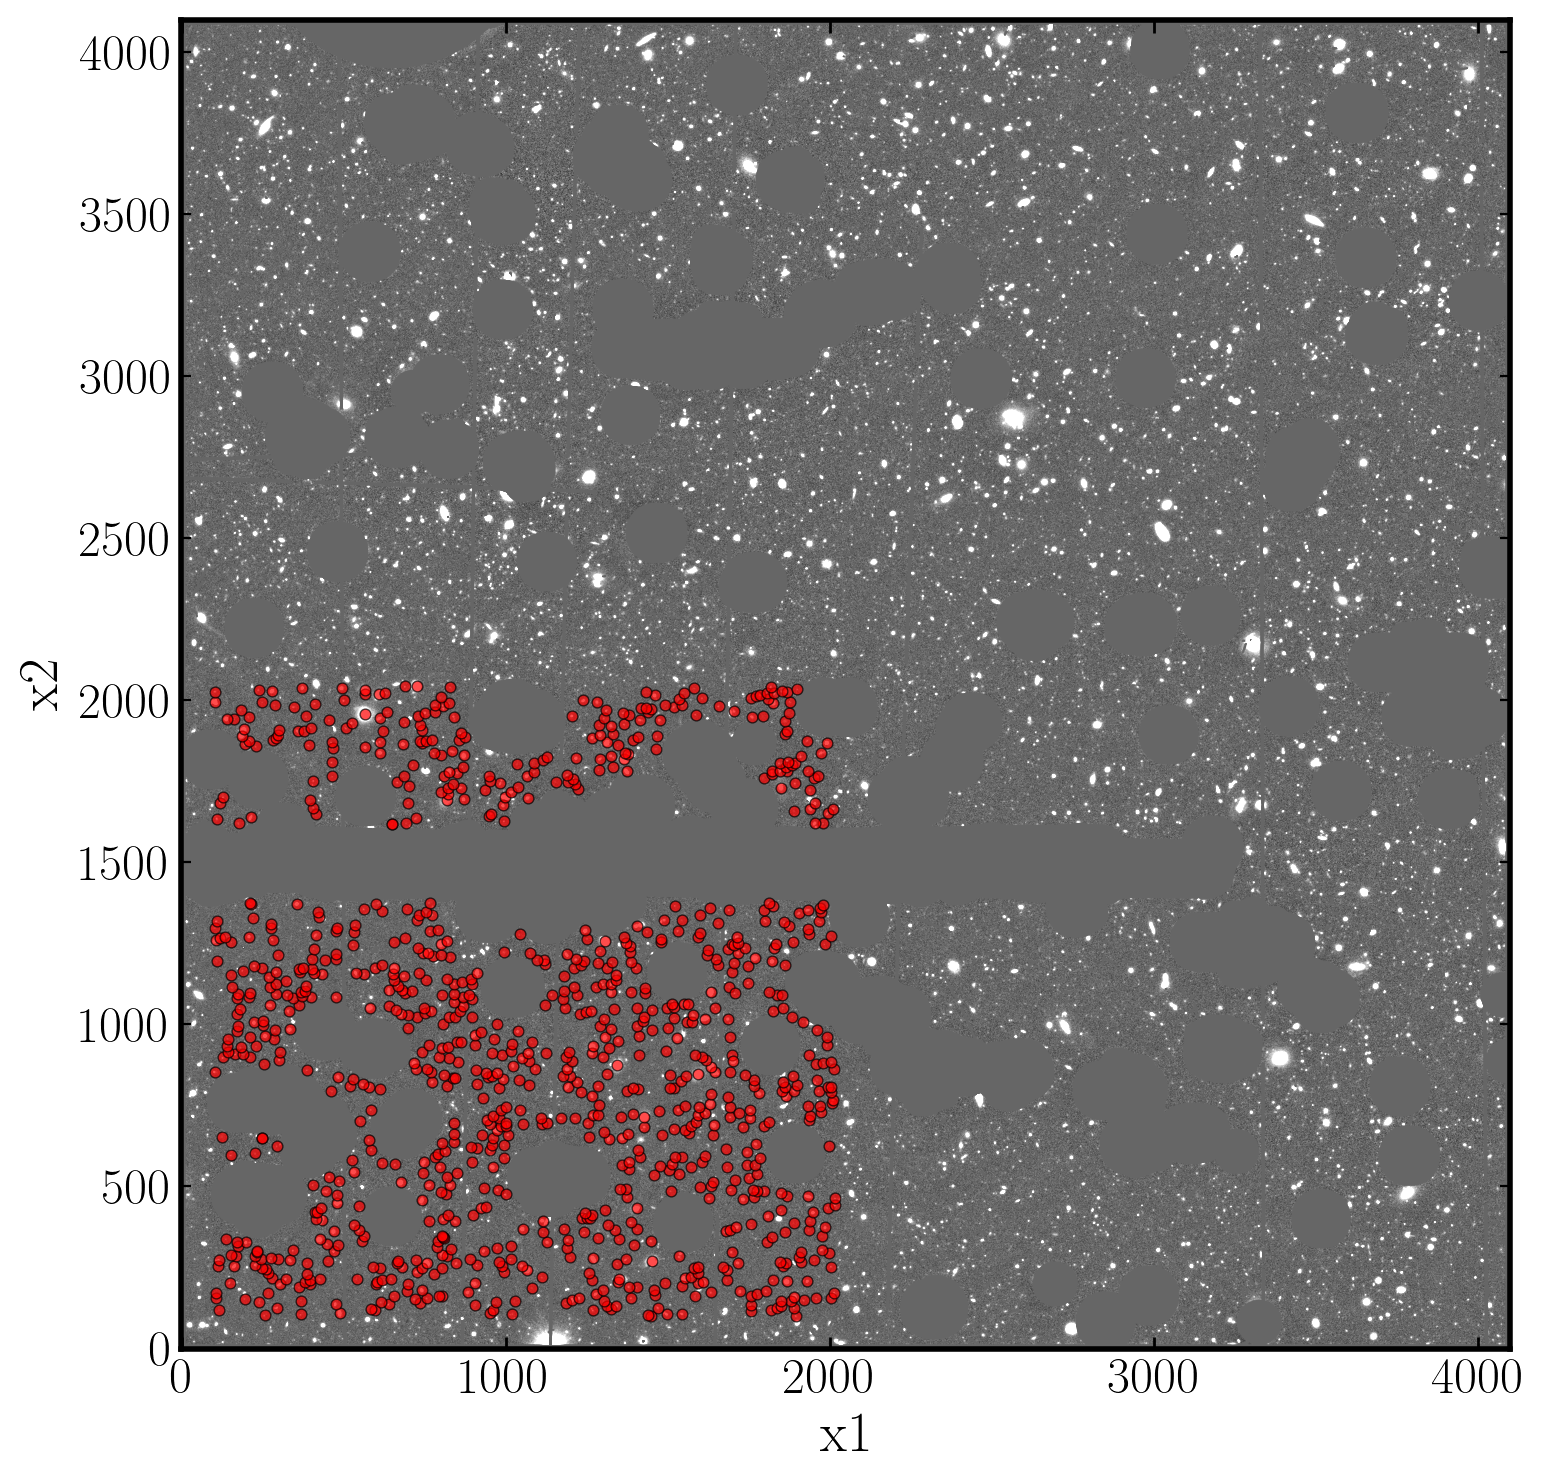

In [11]:
# Example inputs: replace with your actual data
image = data["gal_array"]
bb = exposure.getBBox()
x1 = catalog["x1"] / 0.168 - bb.beginX
x2 = catalog["x2"] / 0.168 - bb.beginY

# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
ax.scatter(x1, x2, s=15, c='red', edgecolors='black', linewidths=0.5, alpha=0.7)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

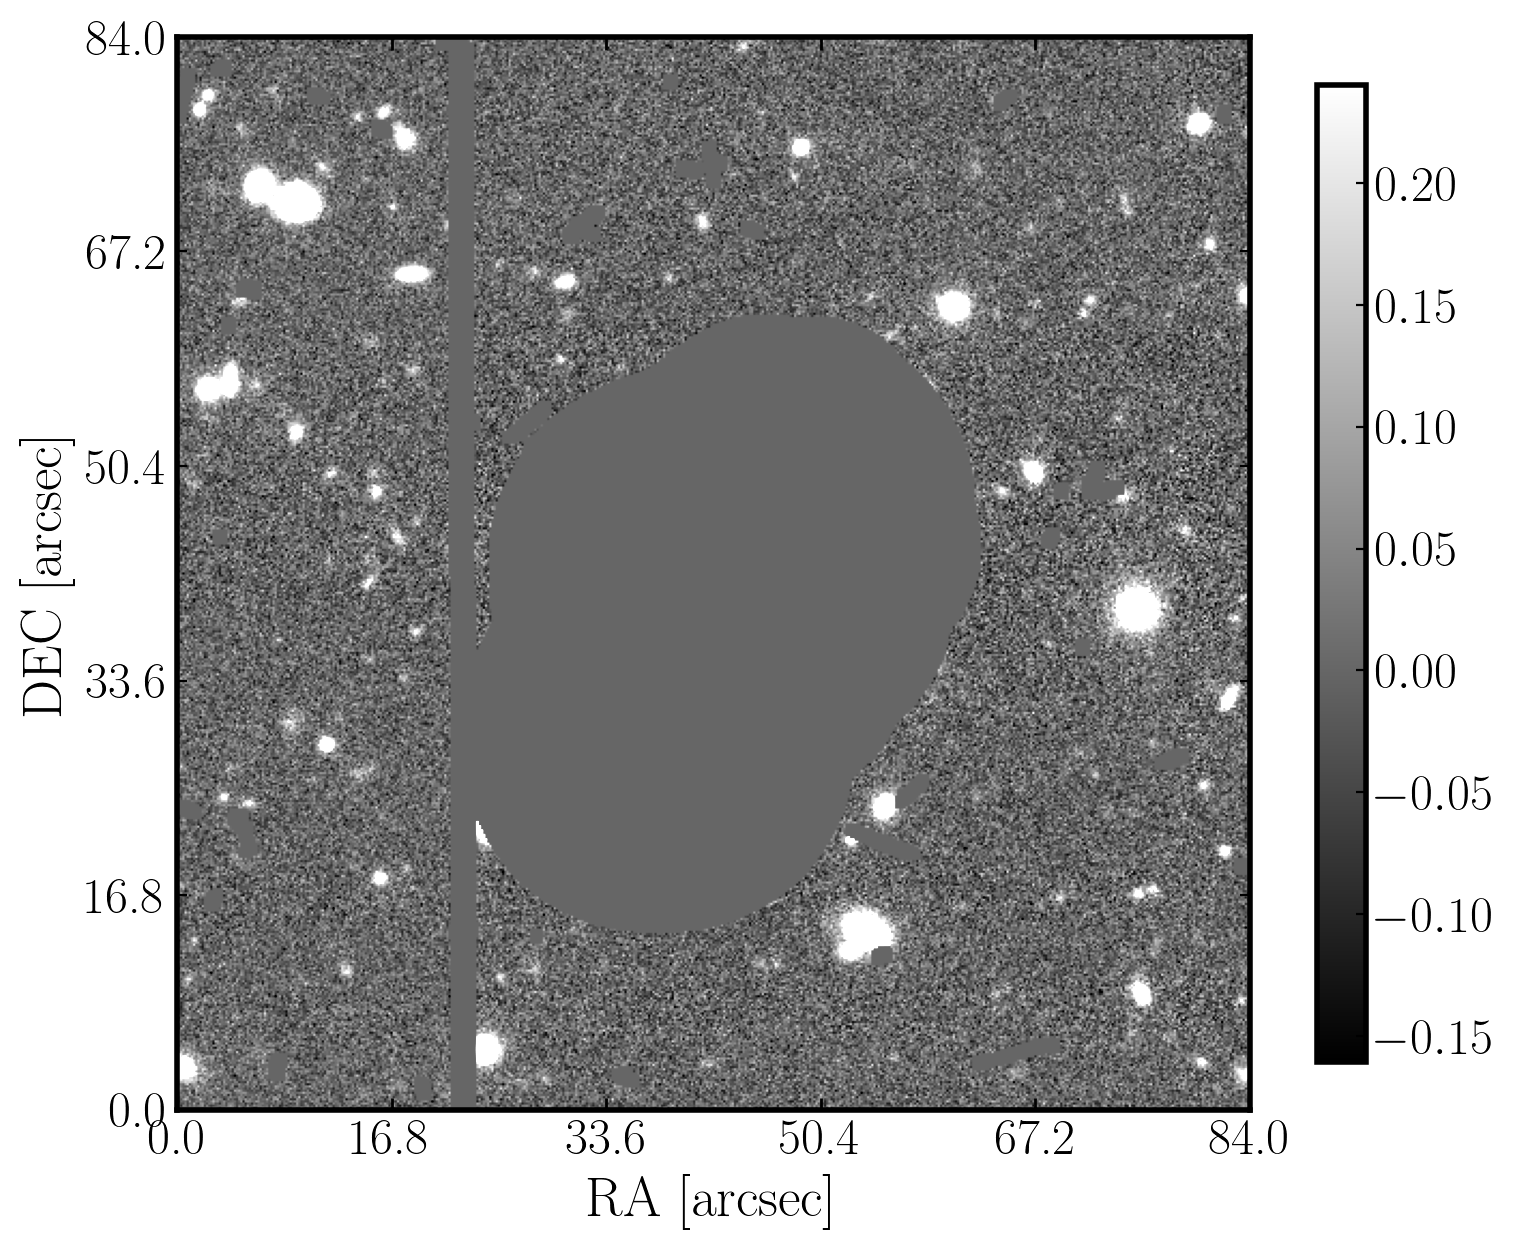

In [12]:
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

xmin = 3200
ymin = 2500
xmax =xmin+500
ymax = ymin+500
pixel_scale = 0.168
# Example inputs: replace with your actual data
image = data["gal_array"]
gm = (catalog["mask_value"] < 60) 
x1 = catalog["x1"][gm] / pixel_scale - bb.beginX
x2 = catalog["x2"] [gm] / pixel_scale - bb.beginY
msk = (x1> xmin) & (x1< xmax-1) & (x2> ymin-1) & (x2< ymax-1)
x1 = x1[msk] - xmin
x2 = x2[msk] - ymin
a1 = np.sqrt((catalog["a1"][gm] / pixel_scale) **2.0 + 3 ** 2.0)
a2 = np.sqrt((catalog["a2"][gm] / pixel_scale) ** 2.0  + 3 ** 2.0)
theta = catalog["t"][gm] / np.pi * 180.0

# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 7))

im = ax.imshow(image[ymin: ymax, xmin:xmax], origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
patches = [
    Ellipse((xi, yi), width=2*maj, height=2*min_, angle=ang)
    for xi, yi, maj, min_, ang in zip(x1, x2, a1, a2, theta)
]

ax.add_collection(
    PatchCollection(
        patches,
        facecolor='none',
        edgecolor='red',
        linewidth=0.8,
        alpha=1.0,
        zorder=2,
    )
)

pixel_scale = 0.168
xticks = ax.get_xticks()
yticks = ax.get_yticks()
ax.set_xticks(xticks)
ax.set_xticklabels([f"{(tick) * pixel_scale:.1f}" for tick in xticks])
ax.set_yticks(yticks)
ax.set_yticklabels([f"{(tick) * pixel_scale:.1f}" for tick in yticks])
ax.set_xlim(0, (xmax - xmin))
ax.set_ylim(0, (ymax - ymin))
ax.set_xlabel("RA [arcsec]")
ax.set_ylabel("DEC [arcsec]")
cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.05)
fig.tight_layout()
plt.show()

In [13]:
len(catalog)

1015

In [239]:
e1 = catalog["fpfs_e1"] * catalog["wsel"]
r1 = (
    catalog["fpfs_de1_dg1"] *catalog["wsel"]
    + catalog["dwsel_dg1"] * catalog["fpfs_e1"]
)
print(np.sum(e1) / np.sum(r1))

-0.005831625678388133


In [240]:
e1 = catalog["e1"] * catalog["wsel"]
r1 = (
    catalog["de1_dg1"] * catalog["wsel"]
    + catalog["dwsel_dg1"] * catalog["e1"]
)
print(np.sum(e1) / np.sum(r1))

-0.008110990023617958
